In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
import beampipe_parameters
beampipe0=beampipe_parameters.Beampipe()

In [19]:
def layer_boundaries(layer=0, side="L", beampipe=beampipe0, height=60.96, width=60.96,gap=0.4):
    offsetX=-10
    holeX=beampipe.holeX(layer)
    holeR=beampipe.holeR(layer)
    if side=="R":
        offsetX-width/2
        
        phi= np.linspace(-np.pi/2, np.pi/2, 25)
        
        x,y = [offsetX-width/2, offsetX-width/2, -gap/2, -gap/2] + list(holeX-holeR*np.cos(phi)) + [-gap/2,-gap/2, -39.8], \
                 [-height/2,height/2, height/2, holeR]+ list(-holeR*np.sin(phi))+ [-holeR,-height/2, -height/2]
        return Polygon(zip(x,y))
    if side=="L":
        
        phi0 = np.arccos((holeX-gap/2)/holeR)
        #print((np.pi-phi0)/np.pi*2)
        phi = np.linspace(phi0,2*np.pi-phi0, 13)
        
        x=[offsetX+width/2, offsetX+width/2, gap/2] + list(holeX-np.cos(phi)*holeR) + [gap/2, 19.8]
        y=[-height/2,height/2, height/2]+list(holeR*np.sin(phi)) + [-height/2, -height/2]
        return Polygon(zip(x,y))

In [20]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

def cell_positions(layer, poly,
                   R_readout=0.4, sidelength=1.86, debug=False, wall_thickness=0.08, wall_scint_gap=0.01, minCellAreaFraction=1/3):
    if wall_thickness!=0:
        poly=poly.buffer(-wall_thickness/2)
    
    y0=sidelength/2+min(poly.exterior.xy[1])
    
    nrows = int((max(poly.exterior.xy[1])-min(poly.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+1)
    
    y0=(max(poly.exterior.xy[1])+min(poly.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(poly.exterior.xy[0])-min(poly.exterior.xy[0]))/(sidelength*3/2))+2
    x0=min(poly.exterior.xy[0])
    
    
    d={a:[] for a in "x y xh yh row col boundsx boundsy area dimpleshift cropped augmented scint_boundsx scint_boundsy scint_area".split()}
    
    
    shiftX=[-sidelength, 0, sidelength][layer%3]
    shiftY=[0, 0, 0][layer%3]
    
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(nrows):
        for j in range(ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            xh=x
            yh=x
            
            xc=x
            yc=y
            #check if the dimple fits inside the boundaries.
            if not Point(x,y).buffer(R_readout).within(poly):
                hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
                overlap=poly.intersection(hexagon)
                if overlap.area==0:
                    continue
                
                # now see if shifting the dimple to the centroid will allow the dimple to fit
                # otherwise merge with neighbors
                centroid=overlap.centroid
                if not centroid.buffer(R_readout).within(poly):
                    continue
                # now see if the cell's area is more than a specified fraction of a 
                # standard hexagon's area.  otherwise merge with neighbors
                if overlap.area/hexagon.area <  minCellAreaFraction:
                    continue
                xc,yc = centroid.xy
                
                d['dimpleshift'].append(1)
            else :
                d['dimpleshift'].append(0)
            d['x'].append(xc)
            d['y'].append(yc)
            
            d['xh'].append(x)
            d['yh'].append(y)
            
            d['row'].append(i)
            d['col'].append(j)
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if poly.contains(hexagon):
                cropped = 0
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
                #smaller hexagon for the scintillator cell.
                scint_sidelength=sidelength-(wall_thickness/2+wall_scint_gap)/(np.sqrt(3)/2)
                hexagon2=Polygon(zip(x+scint_sidelength*np.cos(phi),y+scint_sidelength*np.sin(phi)))
                d['scint_boundsx'].append(hexagon2.exterior.xy[0])
                d['scint_boundsy'].append(hexagon2.exterior.xy[1])
                d['scint_area'].append(hexagon2.area)
            else :
                cropped = 1
                newpoly=poly.intersection(hexagon)
                #print(newpoly.exterior)
                d['boundsx'].append(newpoly.exterior.xy[0])
                d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                d['scint_boundsx'].append(scint.exterior.xy[0])
                d['scint_boundsy'].append(scint.exterior.xy[1])
                d['scint_area'].append(scint.area)
            
                
            d['cropped'].append(cropped)
            d['augmented'].append(0) # no augmenting at this stage yet.  
    df=pd.DataFrame(d)
    
    #now extend any cells that need extending.  Need to find a better way to do this
    for i in range(len(df)):
        #check if the neighboring cell is a fragment (which is not in the dataframe)
        #.  If so, take a piece of it and add it to the current cell.  
        dc, dr = (1, 1,0, -1, -1,0), (-1, 1,2,1, -1, -2)
        
        for j in range(len(dc)):
            r=df.row[i]+dr[j]
            c=df.col[i]+dc[j]
            if not len(df.query(f'row== {r} and col=={c}')):
                cell=Polygon(zip(df.boundsx[i], df.boundsy[i]))
                #find center of the fragmented 
                x=x0+(df.col[i]+dc[j])*sidelength*3/2+shiftX
                y=y0+sidelength*np.sqrt(3)/2*(df.row[i]+dr[j])+shiftY
                
                corner1 = (x+df.xh[i])/2+(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2-(df.xh[i]-x)/np.sqrt(3)/2
                corner2 = (x+df.xh[i])/2-(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2+(df.xh[i]-x)/np.sqrt(3)/2
                
                
                merge=Polygon([(x,y), corner1, (df.xh[i], df.yh[i]),corner2])
                
                newpoly=unary_union([cell,merge])
                newpoly=poly.intersection(newpoly).simplify(.0001)
                #print(newpoly)
                if not type(newpoly)== Polygon:
                    if debug: print("warning disjointed polygon!", type(newpoly), j)
                    continue
                df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                df.loc[i,"area"]=newpoly.area
                
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                df.loc[i,'scint_area']=scint.area
                
                #if two consecutive neighbors are fragments, merge a larger fraction of both of them into this one
                for dj in 1,:
                    r2=df.row[i]+dr[(j+dj)%6]
                    c2=df.col[i]+dc[(j+dj)%6]
                    if not len(df.query(f'row== {r2} and col=={c2}')):
                        x2=x0+c2*sidelength*3/2+shiftX
                        y2=y0+sidelength*np.sqrt(3)/2*r2+shiftY
                        
                        corner3 = 2*(x+x2)/3-df.xh[i]/3,2*(y+y2)/3-df.yh[i]/3
                        
                        
                        
                        merge=Polygon([(x,y), corner3, (x2,y2), (df.xh[i], df.yh[i])])
                        #print(merge.area)
                        newpoly=unary_union([newpoly,merge])
                        newpoly=poly.intersection(newpoly)
                        #print(newpoly)
                        if not type(newpoly)== Polygon:
                            if debug: print("warning disjointed polygon!","XXXX")
                            continue
                        df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                        df.loc[i,"area"]=newpoly.area
                        
                        scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                        df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                        df.loc[i,'scint_area']=scint.area
                        
                tol=1e-7
                if abs(newpoly.area-cell.area)/cell.area>tol:
                    df.loc[i,"augmented"]=1
                
    if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
    return df
            

In [21]:

def draw_layer(layer, R_readout=0.4, sidelength=1.86, fillDimple=True):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    color='krb'[layer%3]
    for side in "LR":
        boundaries=layer_boundaries(layer, side)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color)
        df = cell_positions(layer,boundaries, R_readout, sidelength)
        for i in range(len(df)):
            plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                      linestyle='' if fillDimple else '-',
                                                    fill=fillDimple))
            
            plt.plot(df.boundsx[i], df.boundsy[i], color=color)
                #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

/opt/homebrew/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)


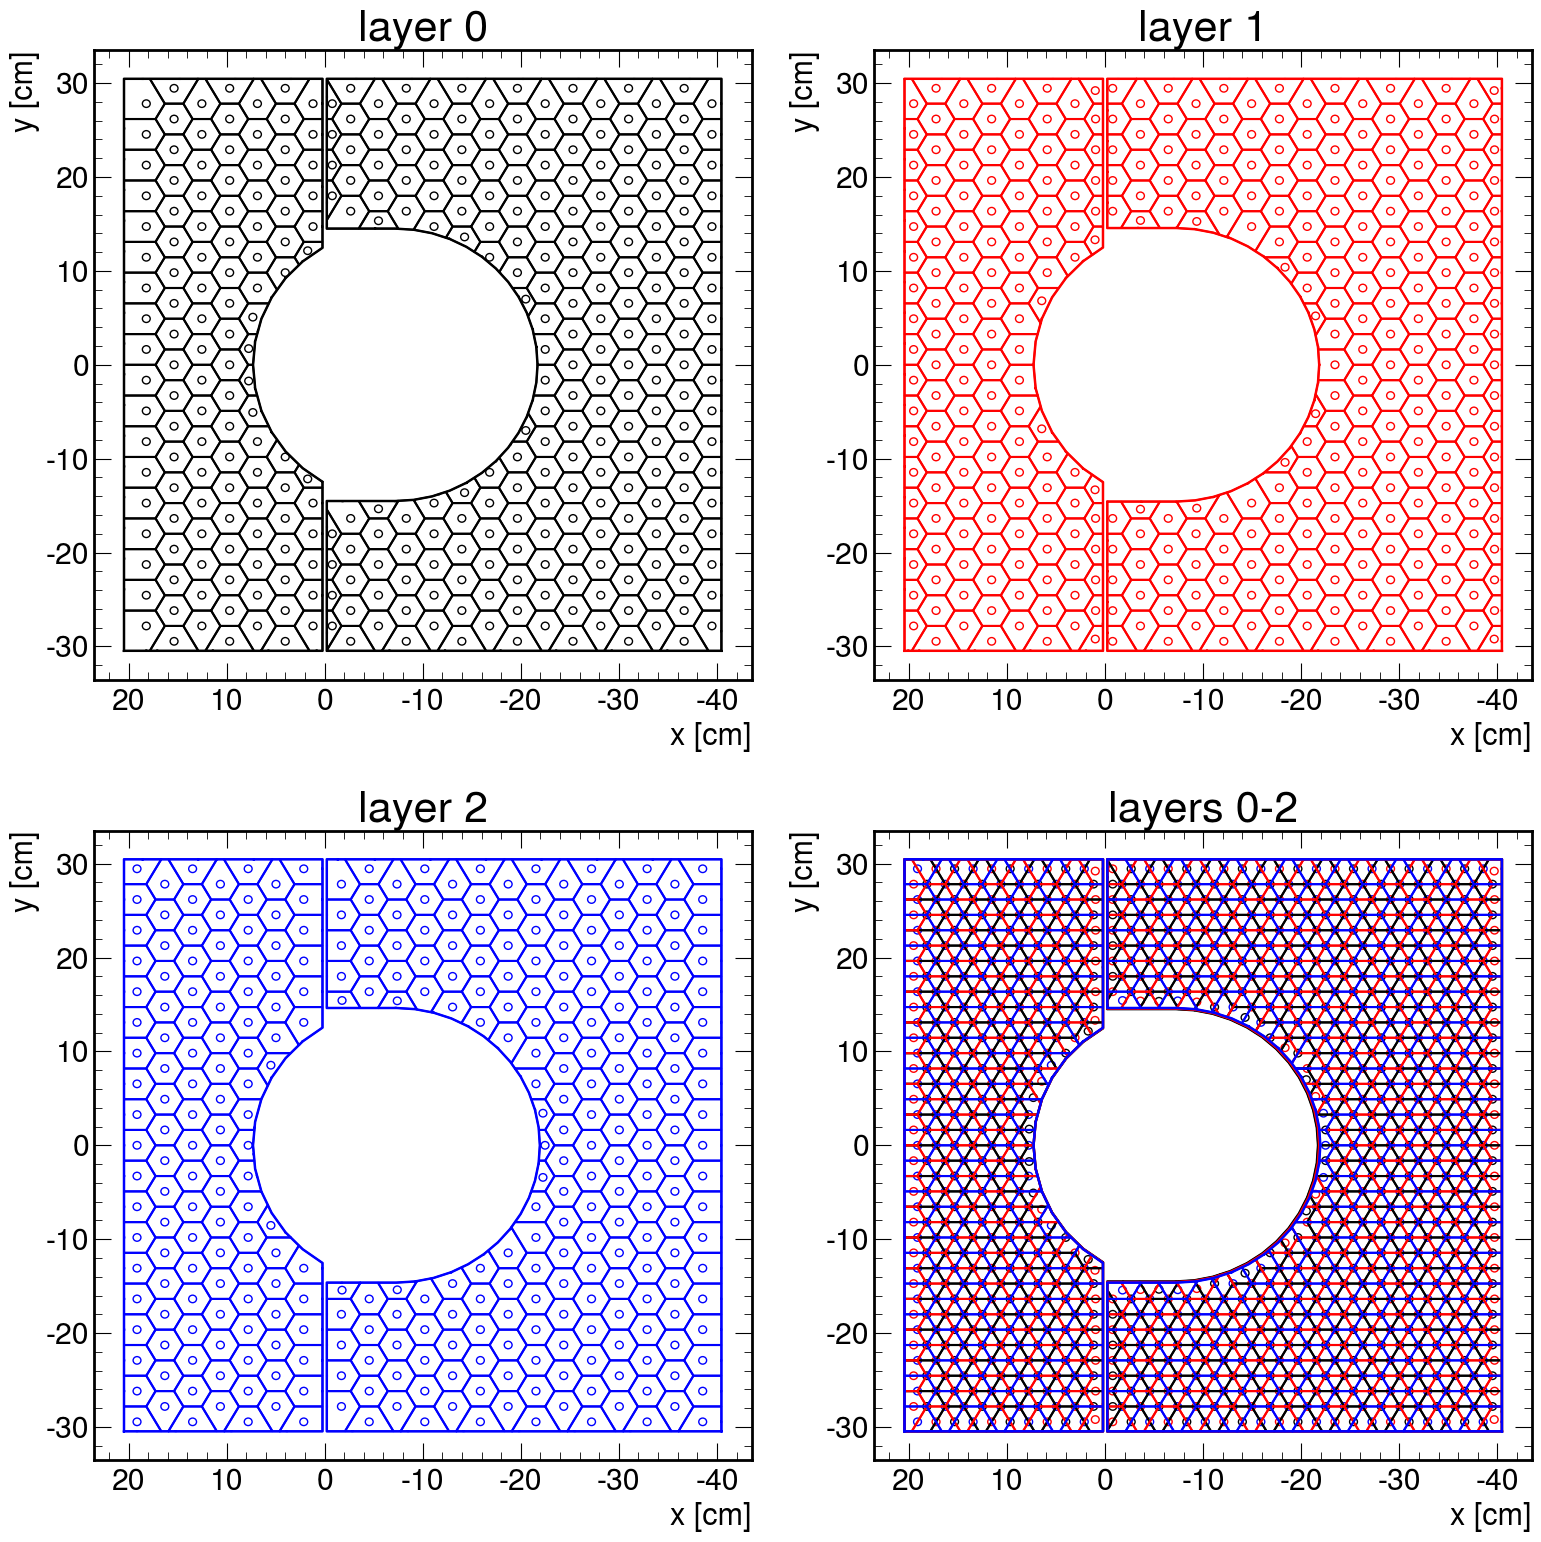

/opt/homebrew/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)


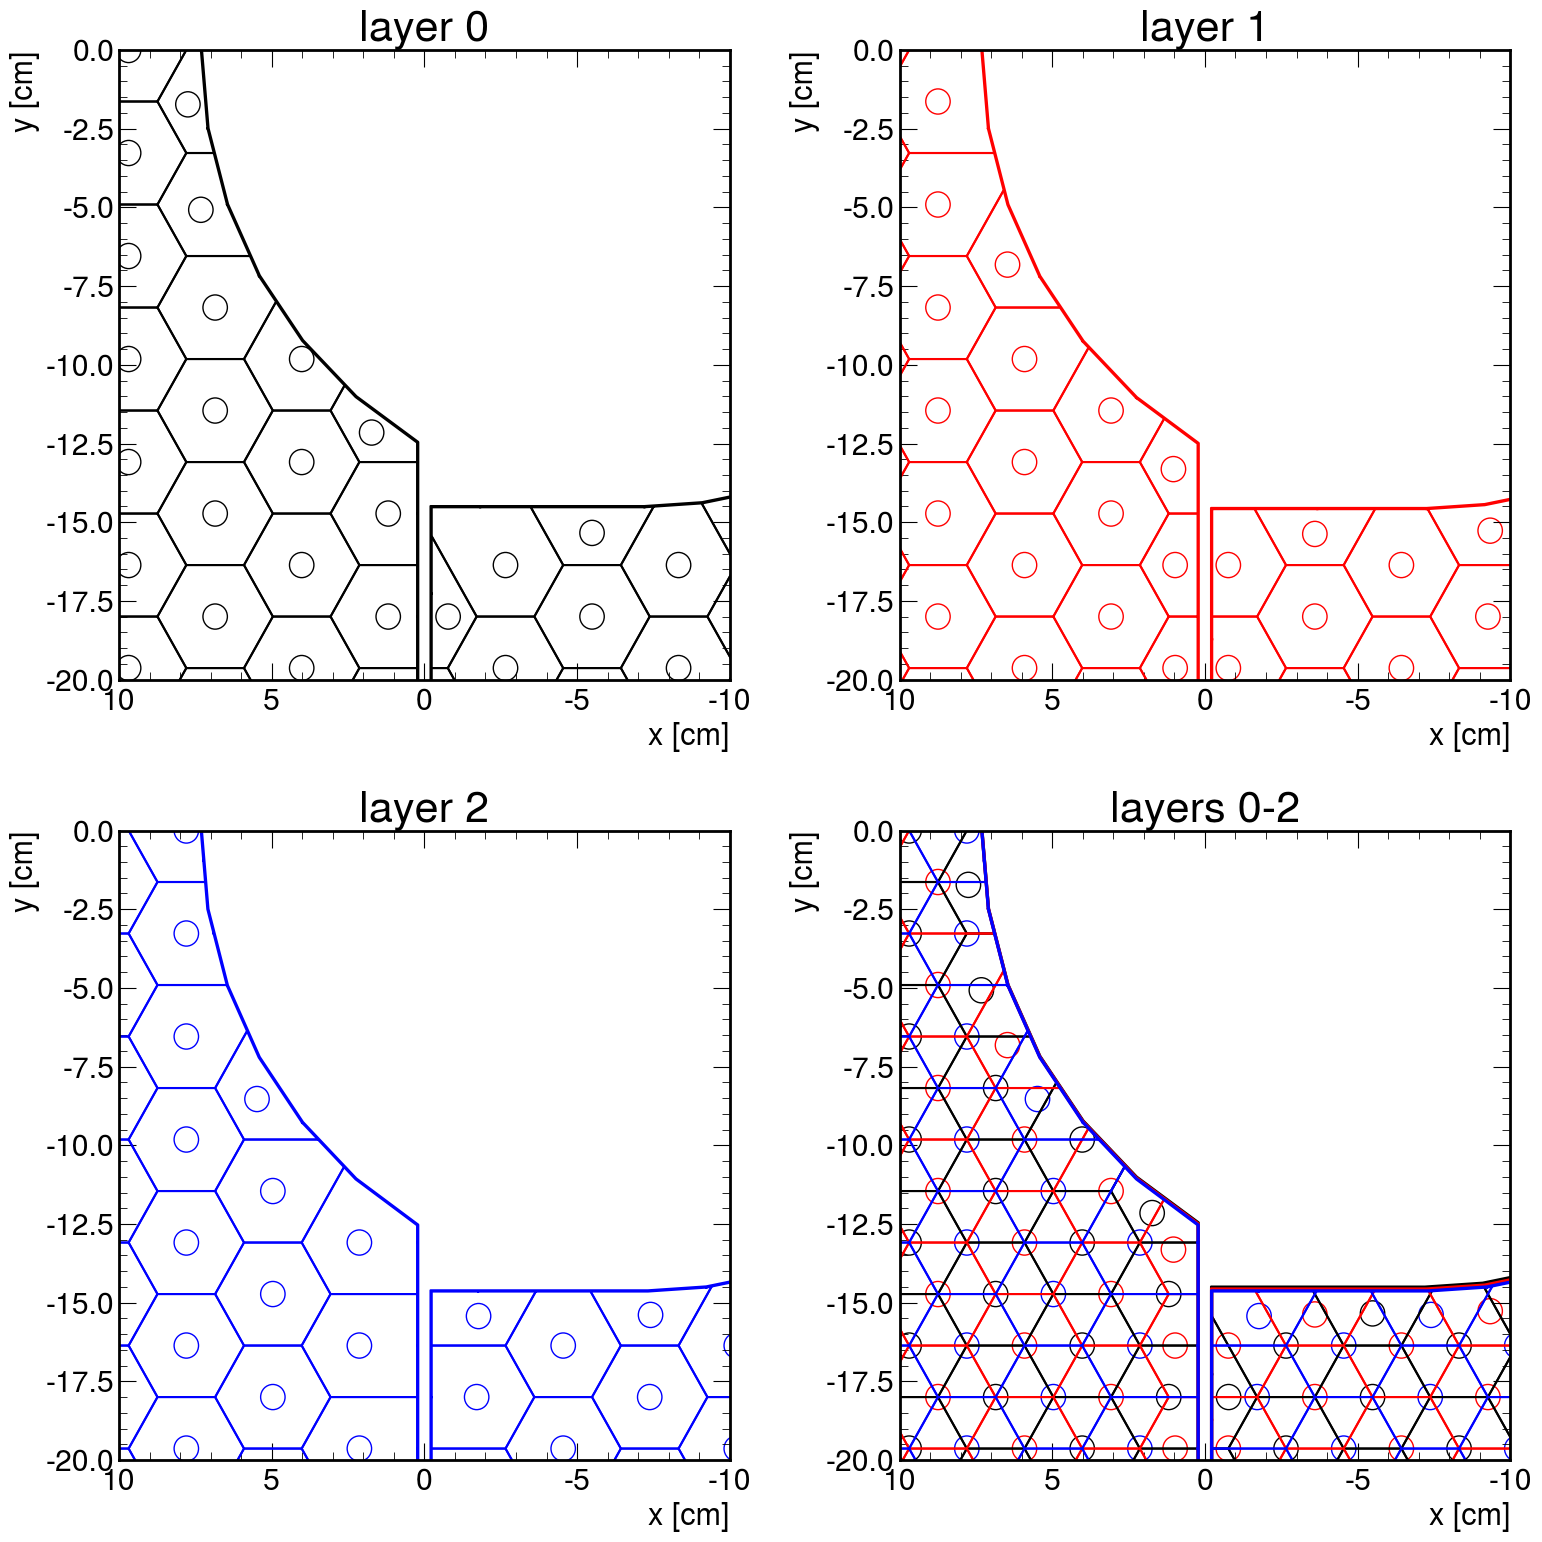

In [94]:
#use sidelength from the model used in the JINST paper
sidelength=1.843
#increase sidelength to account for a wider space between cells
sidelength+=0.04/(np.sqrt(3)/2)

#sidelength=3.722

for zoom in False, True:
    arg=dict(fillDimple=False, sidelength=sidelength)
    fig,axs=plt.subplots(2,2, figsize=(16,16))
    for i in range(3):

        plt.sca(axs[i//2][i%2])
        plt.title(f"layer {i}")
        draw_layer(i, **arg)
        plt.gca().invert_xaxis()
        plt.sca(axs[1][1])
        plt.title(f"layers 0-2")
        draw_layer(i, **arg)
    axs[1][1].invert_xaxis()
    for row in axs:
        for ax in row:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)
            if zoom:
                ax.set_xlim(-10, 10)
                ax.set_ylim(-20, 0)
                ax.invert_xaxis()
    plt.tight_layout()
    plt.savefig(f"Layers_0-2{'_zoom' if zoom else ''}.pdf")
    plt.show()

In [23]:
def print_summary_stats(df, boundary):
    hexagons=df.query("augmented==0 and cropped==0")
    tot_area=boundary.area
    hex_area=sum(hexagons.area)
    
    n_tot = len(df)
    n_hex = len(hexagons)
    print(f"total area: {tot_area:.1f} cm^2")
    print(f"area covered by regular hexagons: {hex_area:.1f} cm^2")
    print(f"(regular hexagon area)/(total area): {100*hex_area/tot_area:.1f}%")
    print(f"total cells: {n_tot}")
    print(f"# of regular hexagon cells: {n_hex}")
    print(f"(regular hexagon cells)/(total cells): {100*n_hex/n_tot:.1f}%")
    
    scint_area=sum(df.scint_area)
    scint_hex_area=sum(df.query("augmented==0 and cropped==0").scint_area)
    
    print(f"scintillator area: {scint_area} cm^2")
    print(f"dead area: {tot_area-scint_area:.1f} cm^2  ({100*(tot_area-scint_area)/scint_area:.1f}%)")
    
    
    print(f"area covered by regular hexagon scintillators: {scint_hex_area:.1f} cm^2 ({100*scint_hex_area/tot_area:.1f}% of total)")
    
    

In [24]:
def write_for_openscad(df, file=None, wall_thickness=0.8, frame_height=3):
    segments=[]
    print("segments=[", file=file)
    lines=[]
    #keep track of 90 degree corners, so that they can be made 90 degree square corners instead of rounded
    corners=[]
    for i in range(len(df)):
        for j in range(len(df.boundsx[i])-1):
            segment = {(df.boundsx[i][j], df.boundsy[i][j]), (df.boundsx[i][j+1], df.boundsy[i][j+1])}
            tol=1e-6
            if j!=0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][j-1])<tol \
                      or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][j-1])<tol) or \
                j==0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][-2])<tol \
                       or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][-2])<tol):
                corner = (df.boundsx[i][j], df.boundsy[i][j])
                #print(corner)
                if corner not in corners:
                    corners.append(corner)
            if segment not in segments:
                lines.append(f"[[{10*df.boundsx[i][j]:.3f},{10*df.boundsy[i][j]:.3f}], [{10*df.boundsx[i][j+1]:.3f}, {10*df.boundsy[i][j+1]:.3f}]]")
                segments.append(segment)
        #print()
    print(",\n".join(lines), file=file)
    print("];", file=file)
    
    #add points for square corners if applicable.  
    if corners:
        print("corners=[", file=file)
        lines=[]
        for corner in corners:
            lines.append(f"  [{10*corner[0]:.3f}, {10*corner[1]:.3f}]")
        print(",\n".join(lines)+"\n];", file=file)
    else:
        print("corners=[];", file=file)
    print(f"wall_thickness={wall_thickness};\nframe_height={frame_height};", file=file)
    print(f"include <make_3d_frame.scad>", file=file)

In [25]:
#use sidelength from the model used in the JINST paper
sidelength=1.843
#increase sidelength to account for a wider space between cells
sidelength+=0.04/(np.sqrt(3)/2)
print(sidelength)

1.88918802153517


In [26]:
#now test this for the first and last layers:
wall_thickness=0.8
frame_height=3

for layer, sidelength in zip((0, 59),(1.889, 3.722)):
    
    scadfile=f"openscad/layer_{layer}.scad"
    with open(scadfile, "w") as f:
        
        for side in "LR":
            #begin new scope for each side
            print(f"module side{side}() {{", file=f)
            #print("{", file=f)

            bounds=layer_boundaries(layer, side, beampipe0)
            df=cell_positions(layer, bounds,
                               R_readout=0.4, sidelength=sidelength)
            print(f"side: {side} layer: {layer}")
            print_summary_stats(df, bounds)
            write_for_openscad(df, file=f, wall_thickness=wall_thickness, frame_height=frame_height)
            print("}", file=f)
            print(f"side{side}();", file=f)
            print()
            
        #now add information to put on the plaque
        holeR, holeX=beampipe0.holeR(layer), beampipe0.holeX(layer)
        print("include <make_plaque.scad>", file=f)
        print("lines=[", file=f)
        def add_line(line):
            print(f'"{line}",', file=f)
        add_line(f"layer {layer}")
        add_line(f"hole radius={holeR:.2f} cm")
        add_line(f"hole position={holeX:.2f} cm")
        add_line(f"side length={sidelength:.2f} cm")
        add_line(f"wall height={frame_height:.1f} mm")
        add_line(f"wall thickness={wall_thickness:.1f} mm")
        print("];", file=f)
        print("plaque(lines);", file=f)
    import os
    try:
        os.mkdir("stl")
    except:
        pass
    try:
        os.mkdir("png")
    except:
        pass
    #assuming you have openscad installed 
    stlfile=f"stl/layer_{layer}.stl"
    pngfile=f"png/layer_{layer}.png"
    
    camera="-200,900,1500,-100,0,0"
    os.system(f'OpenSCAD --camera {camera} --imgsize=1600,1600 -o {pngfile} -o {stlfile} -D pcb_all_layers=true {scadfile}') 

side: L layer: 0
total area: 1112.5 cm^2
area covered by regular hexagons: 649.0 cm^2
(regular hexagon area)/(total area): 58.3%
total cells: 118
# of regular hexagon cells: 70
(regular hexagon cells)/(total cells): 59.3%
scintillator area: 1040.9432162787944 cm^2
dead area: 71.6 cm^2  (6.9%)
area covered by regular hexagon scintillators: 609.9 cm^2 (54.8% of total)

side: R layer: 0
total area: 1923.8 cm^2
area covered by regular hexagons: 1344.3 cm^2
(regular hexagon area)/(total area): 69.9%
total cells: 217
# of regular hexagon cells: 145
(regular hexagon cells)/(total cells): 66.8%
scintillator area: 1797.6088858828073 cm^2
dead area: 126.2 cm^2  (7.0%)
area covered by regular hexagon scintillators: 1263.3 cm^2 (65.7% of total)



Fontconfig warning: "/Applications/OpenSCAD.app/Contents/Resources/fonts/fonts.conf", line 84: unknown element "blank"
Compiling design (CSG Products normalization)...
Normalized CSG tree has 4 elements
Geometries in cache: 4812
Geometry cache size in bytes: 2878560
CGAL Polyhedrons in cache: 0
CGAL cache size in bytes: 0
Total rendering time: 0:00:00.432
ERROR: The given mesh is not closed! Unable to convert to CGAL_Nef_Polyhedron.
Geometries in cache: 4814
Geometry cache size in bytes: 3676624
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 17836816
Total rendering time: 0:00:10.969
Top level object is a 3D object:
   Simple:        yes
   Vertices:     7514
   Halfedges:   22542
   Edges:       11271
   Halffacets:   7800
   Facets:       3900
   Volumes:         3


side: L layer: 59
total area: 1093.3 cm^2
area covered by regular hexagons: 431.9 cm^2
(regular hexagon area)/(total area): 39.5%
total cells: 36
# of regular hexagon cells: 12
(regular hexagon cells)/(total cells): 33.3%
scintillator area: 1050.8398872146674 cm^2
dead area: 42.4 cm^2  (4.0%)
area covered by regular hexagon scintillators: 418.6 cm^2 (38.3% of total)

side: R layer: 59
total area: 1572.1 cm^2
area covered by regular hexagons: 216.0 cm^2
(regular hexagon area)/(total area): 13.7%
total cells: 43
# of regular hexagon cells: 6
(regular hexagon cells)/(total cells): 14.0%
scintillator area: 1516.2484879016397 cm^2
dead area: 55.8 cm^2  (3.7%)
area covered by regular hexagon scintillators: 209.3 cm^2 (13.3% of total)



Fontconfig warning: "/Applications/OpenSCAD.app/Contents/Resources/fonts/fonts.conf", line 84: unknown element "blank"
Compiling design (CSG Products normalization)...
Normalized CSG tree has 4 elements
Geometries in cache: 1531
Geometry cache size in bytes: 1631616
CGAL Polyhedrons in cache: 0
CGAL cache size in bytes: 0
Total rendering time: 0:00:00.279
Geometries in cache: 1533
Geometry cache size in bytes: 2465392
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 18598912
Total rendering time: 0:00:12.058
Top level object is a 3D object:
   Simple:        yes
   Vertices:     7830
   Halfedges:   23490
   Edges:       11745
   Halffacets:   8122
   Facets:       4061
   Volumes:         4


In [143]:
#now tabulate all layers, and also create a dataframe that contains the summary variables
all_layers ={}
beampipe=beampipe0
sidelengths=[1.889]*6+[3.102]*6 + [3.722]*48
#sidelengths=[3.722]*60
#sidelengths=[1.889]*15+[5]*12 + [6]*33
sidelengths=[1.889]*9+[2.5*np.sqrt(2)]*9+[3*np.sqrt(2)]*42
d={a:[] for a in "layer side holeX holeR deadzone_frac channels reg_hexes sidelength".split()}
for layer in range(len(sidelengths)):
    holex=beampipe.holeX(layer)
    holer=beampipe.holeR(layer)
    for side in "LR":
        sidelength=sidelengths[layer]
        bounds=layer_boundaries(layer, side)
        df_layer_side=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelength,minCellAreaFraction=1/2)
        all_layers[(layer, side)]=df_layer_side
        d['layer'].append(layer)
        d['side'].append(side)
        d['holeX'].append(holex)
        d['holeR'].append(holer)
        tot_area=bounds.area
        scint_area=sum(df_layer_side.scint_area)
        deadzone_frac = (tot_area-scint_area)/tot_area
        d['deadzone_frac'].append(deadzone_frac)
        d['channels'].append(len(df_layer_side))
        d['reg_hexes'].append(len(df_layer_side.query('augmented==0 and cropped==0')))
        d['sidelength'].append(sidelength)
summary=pd.DataFrame(d)

In [144]:
print(f"side length (cm)  area (cm^2)   layers  channels")
for s in set(summary.sidelength):
    nlay=len(summary.query(f'sidelength=={s}'))/2
    nchan=sum(summary.query(f'sidelength=={s}').channels)
    #print(f"{s:.1f}")
    print(f"{s:.3f}\t\t{s**2*np.sqrt(3)*3/2:.2f}\t\t{nlay:.0f}\t{nchan}")
print("total layers:", len(summary)/2)
print("total channels:", sum(summary.channels))
print("total regular hexes:", sum(summary.reg_hexes))

side length (cm)  area (cm^2)   layers  channels
1.889		9.27		9	2910
3.536		32.48		9	760
4.243		46.77		42	2540
total layers: 60.0
total channels: 6210
total regular hexes: 2479


In [11]:
for layer, side in all_layers:
    with open(f"openscad/boundaries_{layer}_{side}.scad", "w") as f:
        write_for_openscad(all_layers[(layer,side)], file=f)

In [128]:
np.sqrt(100/(np.sqrt(3)*3/2))

6.204032394013997

In [63]:
5*0.204, 3*0.456

(1.02, 1.368)

In [11]:
beampipe0.holeX(0)

-7.204766203101552

In [12]:
(15.86-11.72)*2.54+0.2

10.715599999999997

In [16]:
beampipe0.holeR(0)-5.62*2.54

0.2114743971985984

In [18]:
15.86+0.2/2.54+beampipe0.holeX(0)/2.54

13.10221803027498

In [43]:
beampipe0.holeX(59)

-10.631402971485745